In [1]:
# project source code
import fann
# syntax utils
from typing import Tuple
from importlib import reload
# data loading
import sklearn.datasets as datasets
# data structures
import pandas as pd
# calculations and algorithms
import numpy as np
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import sklearn
from sklearn.neural_network import MLPClassifier as RefModel  # reference implementation
# visualization
import matplotlib.pyplot as plt

# utility functions

not important to read every single line of every single one

In [2]:
NUM_FEATURES = 2  # aka num of neurons on input layer
NUM_CATEGORIES = 2  # aka num of neurons on output layer
LAYER_SZ = (4, 3)  # first hidden layer has 4 neurons, second hidden layer has 3 neurons


def lrange(*args) -> list:
    return list(range(*args))


def gen_data(n: int=256, noise: float=0.32, random_seed: int=1337, x_scaler: object=None) ->\
    (pd.DataFrame, pd.Series, object):
    X, y = sklearn.datasets.make_moons(n_samples=n, noise=noise, random_state=random_seed)
    assert X.shape[1] == NUM_FEATURES, (len(X), NUM_FEATURES)
    assert len(set(y)) == NUM_CATEGORIES, (len(set(y)), NUM_CATEGORIES)
    x_scaler = sklearn.preprocessing.StandardScaler().fit(X) if x_scaler is None else x_scaler
    X = x_scaler.transform(X)
    X = pd.DataFrame(X)
    y = pd.Series(y)
    return X, y, x_scaler


def convert_ref_to_homebrew(ref_model: RefModel, layer_sz: Tuple[float]=LAYER_SZ) -> fann.NN:
    model = []

    # hidden layers
    bias_index = -1
    # init: in 1st iteration, each neuron on input layer will get weighted & fed into each neuron on 1st layer
    prev_neuron_indices = lrange(NUM_FEATURES)
    for l, sz in enumerate(layer_sz):
        curr_neuron_indices = lrange(sz)

        layer = fann.NNLayer(index=curr_neuron_indices, columns=[bias_index] + prev_neuron_indices)
        # populate bias weights
        layer.loc[:, bias_index] = ref_model.intercepts_[l]
        # populate non-bias weights
        layer.loc[:, prev_neuron_indices] = ref_model.coefs_[l].T
        fann.assert_isinstance_nnlayer(layer)
        model.append(layer)
        del layer

        # in next iteration, each neuron on this layer will get weighted & fed into each neuron on next layer
        prev_neuron_indices = curr_neuron_indices
        del curr_neuron_indices
        del sz
        del l
    model = pd.concat(model, keys=lrange(len(layer_sz)))
    fann.assert_isinstance_nn(model)

    # output layer
    if NUM_CATEGORIES != 2:
        raise ValueError("In this last step, I'm assuming binary classification!")
    # using the single column index `0` (or `1`) is the part that assumes binary classification
    # populate bias weight
    # (both output neurons should have same bias..)
    model.loc[pd.IndexSlice[len(layer_sz), 0], bias_index] = ref_model.intercepts_[-1][0]  # -1 extracts last layer
    model.loc[pd.IndexSlice[len(layer_sz), 1], bias_index] = ref_model.intercepts_[-1][0]
    # populate non-bias weights
    # (.. but opposite weights)
    model.loc[pd.IndexSlice[len(layer_sz), 0], prev_neuron_indices] = -ref_model.coefs_[-1].T[0]
    model.loc[pd.IndexSlice[len(layer_sz), 1], prev_neuron_indices] = ref_model.coefs_[-1].T[0]
    del prev_neuron_indices
    del bias_index
    del layer_sz
    fann.assert_isinstance_nn(model)

    return model


def plot_data(X: pd.DataFrame, y: pd.Series, title: str=None, ax: plt.matplotlib.axes._base._AxesBase=None) -> None:
    ax = plt if ax is None else ax
    # caution: in scatterplot, `x` is actually X[0] i.e. the 1st feature, `y` is X[1] i.e. 2nd feature
    ax.scatter(x=X[0], y=X[1], c=y, cmap=plt.cm.coolwarm)
    try:
        ax.set_title(title)
    except AttributeError:
        ax.title(title)
    if ax == plt:
        ax.show()


def plot_datas(X0: pd.DataFrame, y0: pd.Series, X1: pd.DataFrame, y1: pd.Series,
               title0: str=None, title1: str=None, suptitle: str=None) -> None:
    _, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    plot_data(X=X0, y=y0, title=title0, ax=axs[0])
    plot_data(X=X1, y=y1, title=title1, ax=axs[1])
    if suptitle is not None:
        plt.suptitle("Training Data")
    plt.show()
    
    
def plot_perf(X: pd.DataFrame, y: pd.Series, y_hat: pd.Series, suptitle: str=None) -> None:
    score = np.mean(y_hat == y)
    plot_datas(X0=X, y0=y, title0="Ground Truth",
               X1=X, y1=y_hat, title1="Model (score = {score:.2f}%)".format(score=score * 100),
               suptitle=suptitle)

# construct datasets

In [3]:
X_train, y_train, x_scaler = gen_data()
# for simplicity, we pretend we know ground-truth optimal hyperparameters -> don't need tuning data
# X_tune, y_tune, _ = gen_data(random_seed=1337+1, x_scaler=x_scaler)
X_test, y_test, _ = gen_data(random_seed=1337+2, x_scaler=x_scaler)

In [4]:
# preview
pd.concat([X_train, y_train], axis="columns", keys=["X_train", "y_train"])

X_train           y_train
            0         1       0
0   -1.720010 -0.592602       0
1   -0.263360  1.315617       0
2   -0.811233  0.593363       0
3    0.108340  1.623423       0
4   -0.252440 -0.046977       1
..        ...       ...     ...
251  0.370235 -1.117875       1
252  1.783155 -0.707722       1
253 -1.453746  0.273004       0
254  1.045813 -0.978903       1
255 -0.767574 -0.051766       1

[256 rows x 3 columns]

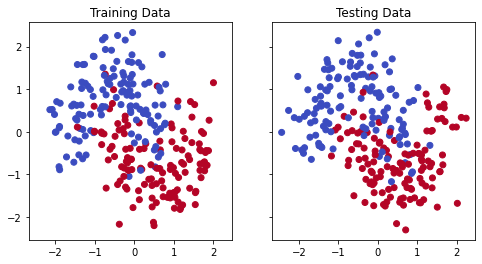

In [5]:
plot_datas(X0=X_train, y0=y_train, title0="Training Data", X1=X_test, y1=y_test, title1="Testing Data")

# "cheat" off a reference model

In [6]:
ref_model = RefModel(hidden_layer_sizes=LAYER_SZ, activation="logistic",
                     solver="lbfgs", max_iter=2048, random_state=1337).fit(X=X_train, y=y_train)

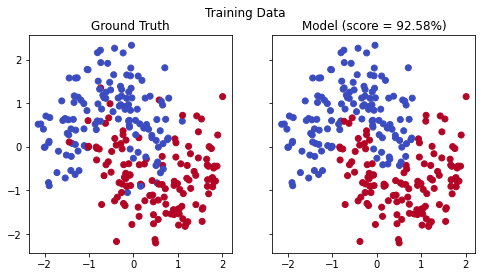

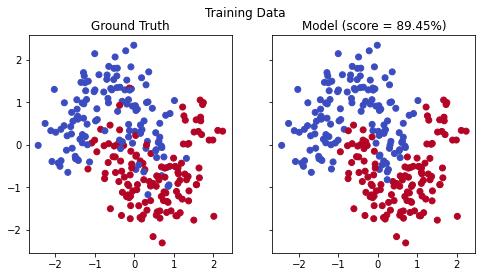

In [7]:
plot_perf(X=X_train, y=y_train, y_hat=ref_model.predict(X=X_train), suptitle="Training Data")
plot_perf(X=X_test, y=y_test, y_hat=ref_model.predict(X=X_test), suptitle="Testing Data")

## replicate

In [8]:
model = convert_ref_to_homebrew(ref_model=ref_model)
model

-1          0          1          2          3
0 0   0.873385   3.944629  -0.841650        NaN        NaN
  1  22.316308 -12.993556  16.603979        NaN        NaN
  2 -25.552951  30.081200 -11.800556        NaN        NaN
  3  -1.068344   4.525354  -0.518800        NaN        NaN
1 0 -25.782396  -9.737237  25.080410 -40.164008  51.412467
  1  25.630496  18.716913 -33.278286  50.685572  -9.136564
  2  15.599658   7.432398  -6.167783  11.372810  -1.191241
2 0   3.980336  74.614951 -54.646973 -16.600309        NaN
  1   3.980336 -74.614951  54.646973  16.600309        NaN

In [9]:
# sklearn uses single output neuron & predicts category label (0 or 1) based on whether its activation < or >= 0.50..
# we use 2 output neurons & predict category label (0 or 1) based on whose activation is stronger.
# but, in replicating sklearn's model, we make our first output neuron (0) a dummy whose activation is
# always exactly equal to the complement of the second output neuron (1) activation.
# note that this means we don't need to "squash" our output before assigning probabilities to category labels,
# or making a final prediction: our output is "pre-squashed". of course, because our code doesn't know this,
# it will squash anyway, but the squashing won't have any effect.
# the following assertions just "prove" that we did the arithmetic correctly; take them apart to see how.
assert np.alltrue(np.isclose(fann.fprop_(X=X_train, nn=model).sum(axis="columns"), 1.00))
assert np.alltrue(np.isclose(fann.fprop_(X=X_test, nn=model).sum(axis="columns"), 1.00))

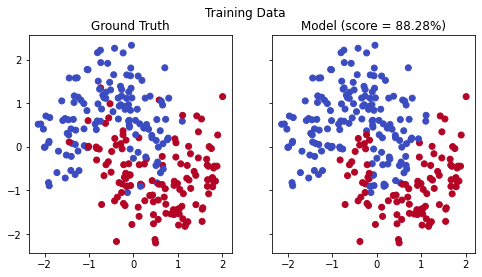

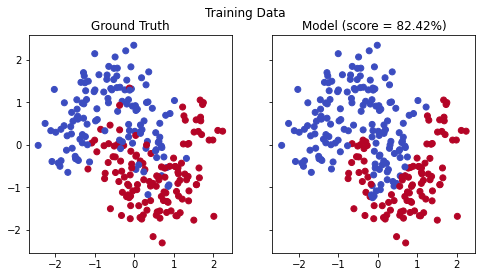

In [10]:
plot_perf(X=X_train, y=y_train, y_hat=fann.predict(X=X_train, nn=model), suptitle="Training Data")
plot_perf(X=X_test, y=y_test, y_hat=fann.predict(X=X_test, nn=model), suptitle="Testing Data")

`# TODO(sparshsah): why don't i exactly match sklearn's predictions?`

# train our own homebrew model from scratch